# Libraries

In [1]:
import pickle
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.utils import resample

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

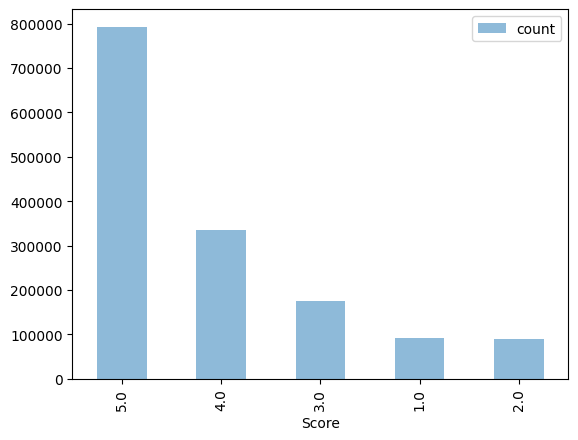


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def add_features_to(df):
    # This is where you can do all your feature extraction
    print("Adding features...")

    # Helpfulness Ratio
    print("Calculating Helpfulness ratio...")
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # Product and User Encoding
    print("Encoding ProductId and UserId...")
    product_encoder = LabelEncoder()
    user_encoder = LabelEncoder()
    df['ProductEncoded'] = product_encoder.fit_transform(df['ProductId'].fillna(''))
    df['UserEncoded'] = user_encoder.fit_transform(df['UserId'].fillna(''))

    # TF-IDF for Text and Summary
    print("Vectorizing Text and Summary with TF-IDF...")
    tfidf = TfidfVectorizer(max_features=1000)
    text_tfidf = tfidf.fit_transform(df['Text'].fillna(''))
    summary_tfidf = tfidf.fit_transform(df['Summary'].fillna(''))

    # SVD to reduce dimensionality of text data
    print("Applying SVD to reduce dimensionality of text features...")
    svd = TruncatedSVD(n_components=50, random_state=42)
    text_svd = svd.fit_transform(text_tfidf)
    summary_svd = svd.fit_transform(summary_tfidf)

    # Clustering reviews based on text for added feature
    print("Clustering reviews into groups using KMeans...")
    kmeans = KMeans(n_clusters=5, random_state=42)
    text_cluster = kmeans.fit_predict(text_tfidf)

    # Create a new DataFrame with all the new features
    print("Concatenating all features into the DataFrame...")
    svd_columns_text = pd.DataFrame(text_svd, columns=[f'text_svd_{i}' for i in range(50)])
    svd_columns_summary = pd.DataFrame(summary_svd, columns=[f'summary_svd_{i}' for i in range(50)])
    cluster_column = pd.DataFrame(text_cluster, columns=['TextCluster'])
    
    # Concatenate all new features at once to avoid fragmentation
    df = pd.concat([df, svd_columns_text, svd_columns_summary, cluster_column], axis=1)
    
    print("Feature extraction complete.\n")
    return df

# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    print("Loading pre-saved processed data...")
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    print("Processing training data for feature extraction...")
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

Loading pre-saved processed data...


# Sample + Split into training and testing set

In [4]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train.drop(columns=['Score']),
    X_train['Score'],
    test_size=1/4.0,
    random_state=0
)

X_train['Score'] = Y_train

# Separate majority and minority classes
df_majority = X_train[X_train['Score'] == 5]
df_minority = X_train[X_train['Score'] != 5]

# Downsample majority class (5-star ratings)
df_majority_downsampled = resample(df_majority, 
                                   replace=False,    
                                   n_samples=len(df_minority), 
                                   random_state=42)  

# Combine minority class with downsampled majority class
X_train_balanced = pd.concat([df_minority, df_majority_downsampled])

# Separate features and labels after resampling
Y_train_balanced = X_train_balanced['Score']
X_train_balanced = X_train_balanced.drop(columns=['Score'])

# Feature Selection

In [5]:
features = (
    [f'text_svd_{i}' for i in range(50)] + 
    [f'summary_svd_{i}' for i in range(50)] +
    ['Helpfulness', 'ProductEncoded', 'UserEncoded','TextCluster']
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced[features])
X_test_scaled = scaler.transform(X_test[features])
X_submission_scaled = scaler.transform(X_submission[features])

# Model Creation

In [6]:
# Learn the model
model = KNeighborsClassifier(n_neighbors=200).fit(X_train_scaled, Y_train_balanced)

# Predict and evaluate on test set
Y_test_predictions = model.predict(X_test_scaled)
print("Accuracy on testing set =", accuracy_score(Y_test, Y_test_predictions))

Accuracy on testing set = 0.5773908266367925


# Model Evaluation

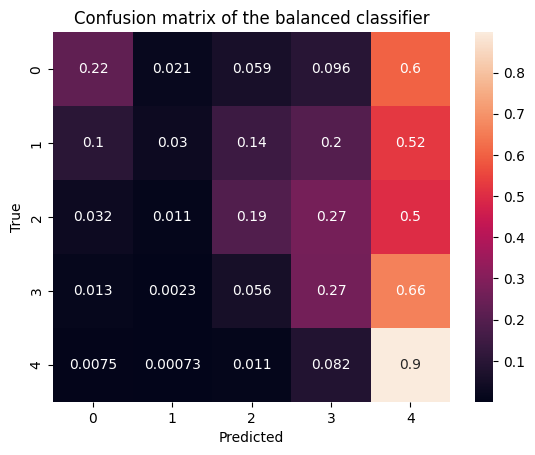

In [7]:
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the balanced classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [8]:
X_submission['Score'] = model.predict(X_submission_scaled)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission2.csv", index=False)